In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=827e0a73f2fb29643bf0af69aff8a8dc9f55ecd3c6624ff9672faf15b8684a89
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
spark = SparkSession.builder.appName('BDA').getOrCreate()
spark

**Events dataset**

---



---



In [ ]:
eventsDf = spark.read.options(header="true",\
                              inferSchema="true",\
                              nullValue="NA",\
                              mode="failfast")\
                             .csv("/content/drive/MyDrive/bdaproj/events.csv")

In [ ]:
print('Data is having', eventsDf.count(), "rows and", len(eventsDf.columns), 'columns')

Data is having 941009 rows and 22 columns


In [ ]:
eventsDf.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|             player|         player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+
|UFot0hit/| UFot0hit1|         1|   2|Attempt missed. M...|         1|         12|   2|       Hamburg SV|Borussia Dortmund|      mladen petric|     gokhan tore|     NULL|      NULL|         6|       

In [ ]:
eventsDf.printSchema()

root
 |-- id_odsp: string (nullable = true)
 |-- id_event: string (nullable = true)
 |-- sort_order: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_type2: integer (nullable = true)
 |-- side: integer (nullable = true)
 |-- event_team: string (nullable = true)
 |-- opponent: string (nullable = true)
 |-- player: string (nullable = true)
 |-- player2: string (nullable = true)
 |-- player_in: string (nullable = true)
 |-- player_out: string (nullable = true)
 |-- shot_place: integer (nullable = true)
 |-- shot_outcome: integer (nullable = true)
 |-- is_goal: integer (nullable = true)
 |-- location: integer (nullable = true)
 |-- bodypart: integer (nullable = true)
 |-- assist_method: integer (nullable = true)
 |-- situation: integer (nullable = true)
 |-- fast_break: integer (nullable = true)



**NULL VALUES CHECKING**

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
tempDF = eventsDf[['player', 'event_team', 'opponent', 'event_type', 'event_type2', 'shot_place',
                   'shot_outcome', 'location', 'bodypart', 'assist_method', 'situation']]

tempDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in tempDF.columns]).show()

+------+----------+--------+----------+-----------+----------+------------+--------+--------+-------------+---------+
|player|event_team|opponent|event_type|event_type2|shot_place|shot_outcome|location|bodypart|assist_method|situation|
+------+----------+--------+----------+-----------+----------+------------+--------+--------+-------------+---------+
| 60736|         0|       0|         0|     726716|    713550|      712511|  473942|  711824|            0|   711872|
+------+----------+--------+----------+-----------+----------+------------+--------+--------+-------------+---------+



**HANDLING NULL VALUES**

In [ ]:
eventsDf = eventsDf.na.fill({'player': 'NA', 'event_team': 'NA', 'opponent': 'NA',
                             'event_type': 'NA', 'event_type2': 'NA', 'shot_place': 'NA',
                             'shot_outcome': 'NA', 'location': 'NA', 'bodypart': 'NA',
                             'assist_method': 'NA', 'situation': 'NA'})

**GAME INFO DATASET**

---



---



In [ ]:
gameDf = spark.read.options(header="true",\
                              inferSchema="true",\
                              nullValue="NA",\
                              mode="failfast")\
                             .csv("/content/drive/MyDrive/bdaproj/ginf.csv")

In [ ]:
print('Data is having', gameDf.count(), "rows and", len(gameDf.columns), 'columns' )

In [ ]:
gameDf.printSchema()

root
 |-- id_odsp: string (nullable = true)
 |-- link_odsp: string (nullable = true)
 |-- adv_stats: boolean (nullable = true)
 |-- date: date (nullable = true)
 |-- league: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- ht: string (nullable = true)
 |-- at: string (nullable = true)
 |-- fthg: integer (nullable = true)
 |-- ftag: integer (nullable = true)
 |-- odd_h: double (nullable = true)
 |-- odd_d: double (nullable = true)
 |-- odd_a: double (nullable = true)
 |-- odd_over: double (nullable = true)
 |-- odd_under: double (nullable = true)
 |-- odd_bts: double (nullable = true)
 |-- odd_bts_n: double (nullable = true)



In [ ]:
gameDf.show(10)

+---------+--------------------+---------+----------+------+------+-------+-------------------+--------------------+----+----+-----+-----+-----+--------+---------+-------+---------+
|  id_odsp|           link_odsp|adv_stats|      date|league|season|country|                 ht|                  at|fthg|ftag|odd_h|odd_d|odd_a|odd_over|odd_under|odd_bts|odd_bts_n|
+---------+--------------------+---------+----------+------+------+-------+-------------------+--------------------+----+----+-----+-----+-----+--------+---------+-------+---------+
|UFot0hit/|/soccer/germany/b...|     true|2011-08-05|    D1|  2012|germany|  Borussia Dortmund|          Hamburg SV|   3|   1| 1.56| 4.41| 7.42|    NULL|     NULL|   NULL|     NULL|
|Aw5DflLH/|/soccer/germany/b...|     true|2011-08-06|    D1|  2012|germany|        FC Augsburg|         SC Freiburg|   2|   2| 2.36|  3.6|  3.4|    NULL|     NULL|   NULL|     NULL|
|bkjpaC6n/|/soccer/germany/b...|     true|2011-08-06|    D1|  2012|germany|      Werder Br

Here, only required columns are selected

In [ ]:
gameDf = gameDf[['id_odsp', 'country', 'adv_stats', 'date', 'league', 'season']]

In [ ]:
gameDf.show(10)

+---------+-------+---------+----------+------+------+
|  id_odsp|country|adv_stats|      date|league|season|
+---------+-------+---------+----------+------+------+
|UFot0hit/|germany|     true|2011-08-05|    D1|  2012|
|Aw5DflLH/|germany|     true|2011-08-06|    D1|  2012|
|bkjpaC6n/|germany|     true|2011-08-06|    D1|  2012|
|CzPV312a/| france|     true|2011-08-06|    F1|  2012|
|GUOdmtII/| france|     true|2011-08-06|    F1|  2012|
|lOpzwMkp/|germany|     true|2011-08-06|    D1|  2012|
|M7PhlM2C/| france|     true|2011-08-06|    F1|  2012|
|QuWqjrYa/| france|     true|2011-08-06|    F1|  2012|
|UBZQ4smg/| france|     true|2011-08-06|    F1|  2012|
|Wn69eU5B/|germany|     true|2011-08-06|    D1|  2012|
+---------+-------+---------+----------+------+------+
only showing top 10 rows



In [ ]:
gameDf.select([count(when(col(c).isNull(), c)).alias(c) for c in gameDf.columns]).show()

+-------+-------+---------+----+------+------+
|id_odsp|country|adv_stats|date|league|season|
+-------+-------+---------+----+------+------+
|      0|      0|        0|   0|     0|     0|
+-------+-------+---------+----+------+------+



**DICTIONARY.txt**

---



---



map values from dictionary to different colums in events dataframe by creating new columns

In [ ]:
evtTypeMap = {0:'Announcement', 1:'Attempt', 2:'Corner', 3:'Foul', 4:'Yellow card', 5:'Second yellow card', 6:'Red card', 7:'Substitution', 8:'Free kick won', 9:'Offside', 10:'Hand ball', 11:'Penalty conceded'}

evtTyp2Map = {12:'Key Pass', 13:'Failed through ball', 14:'Sending off', 15:'Own goal'}

sideMap = {1:'Home', 2:'Away'}

shotPlaceMap = {1:'Bit too high', 2:'Blocked', 3:'Bottom left corner', 4:'Bottom right corner', 5:'Centre of the goal', 6:'High and wide', 7:'Hits the bar', 8:'Misses to the left', 9:'Misses to the right', 10:'Too high', 11:'Top centre of the goal', 12:'Top left corner', 13:'Top right corner'}

shotOutcomeMap = {1:'On target', 2:'Off target', 3:'Blocked', 4:'Hit the bar'}

locationMap = {1:'Attacking half', 2:'Defensive half', 3:'Centre of the box', 4:'Left wing', 5:'Right wing', 6:'Difficult angle and long range', 7:'Difficult angle on the left', 8:'Difficult angle on the right', 9:'Left side of the box', 10:'Left side of the six yard box', 11:'Right side of the box', 12:'Right side of the six yard box', 13:'Very close range', 14:'Penalty spot', 15:'Outside the box', 16:'Long range', 17:'More than 35 yards', 18:'More than 40 yards', 19:'Not recorded'}

bodyPartMap = {1:'Right foot', 2:'Left foot', 3:'Head'}

assistMethodMap = {0:'None', 1:'Pass', 2:'Cross', 3:'Headed pass', 4:'Through ball'}

situationMap = {1:'Open play', 2:'Set piece', 3:'Corner', 4:'Free kick'}

countryCodeMap = {'germany':'DEU', 'france':'FRA', 'england':'GBR', 'spain':'ESP', 'italy':'ITA'}

In [ ]:
eventsDf.groupBy("event_type").count().show()

+----------+------+
|event_type| count|
+----------+------+
|         1|229135|
|         6|  1152|
|         3|232925|
|         5|   100|
|         9| 43476|
|         4| 39911|
|         8|237932|
|         7| 51738|
|        10| 10730|
|        11|  2706|
|         2| 91204|
+----------+------+



udf to map key to values in dict

In [ ]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

def translateKeys(mapping):
    def translateKeys_(col):
        return mapping.get(col)
    return udf(translateKeys_, StringType())

easy access to contry column and spelling mistakes in country names

In [ ]:
gameDf = gameDf.withColumn("country_code", translateKeys(countryCodeMap)("country"))

display(gameDf['id_odsp','country','country_code'])

DataFrame[id_odsp: string, country: string, country_code: string]

In [ ]:
eventsDf = (
             eventsDf.
             withColumn("event_type_str", translateKeys(evtTypeMap)("event_type")).
             withColumn("event_type2_str", translateKeys(evtTyp2Map)("event_type2")).
             withColumn("side_str", translateKeys(sideMap)("side")).
             withColumn("shot_place_str", translateKeys(shotPlaceMap)("shot_place")).
             withColumn("shot_outcome_str", translateKeys(shotOutcomeMap)("shot_outcome")).
             withColumn("location_str", translateKeys(locationMap)("location")).
             withColumn("bodypart_str", translateKeys(bodyPartMap)("bodypart")).
             withColumn("assist_method_str", translateKeys(assistMethodMap)("assist_method")).
             withColumn("situation_str", translateKeys(situationMap)("situation"))
           )

In [ ]:
eventsDf.printSchema()

root
 |-- id_odsp: string (nullable = true)
 |-- id_event: string (nullable = true)
 |-- sort_order: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_type2: integer (nullable = true)
 |-- side: integer (nullable = true)
 |-- event_team: string (nullable = false)
 |-- opponent: string (nullable = false)
 |-- player: string (nullable = false)
 |-- player2: string (nullable = true)
 |-- player_in: string (nullable = true)
 |-- player_out: string (nullable = true)
 |-- shot_place: integer (nullable = true)
 |-- shot_outcome: integer (nullable = true)
 |-- is_goal: integer (nullable = true)
 |-- location: integer (nullable = true)
 |-- bodypart: integer (nullable = true)
 |-- assist_method: integer (nullable = true)
 |-- situation: integer (nullable = true)
 |-- fast_break: integer (nullable = true)
 |-- event_type_str: string (nullable = true)
 |-- event_type2_str: string (nullable = tru

In [ ]:
eventsDf.groupBy("event_type_str").count().show()

+------------------+------+
|    event_type_str| count|
+------------------+------+
|         Hand ball| 10730|
|          Red card|  1152|
|              Foul|232925|
|       Yellow card| 39911|
|           Attempt|229135|
|      Substitution| 51738|
|           Offside| 43476|
|  Penalty conceded|  2706|
|     Free kick won|237932|
|Second yellow card|   100|
|            Corner| 91204|
+------------------+------+



In [ ]:
finalDf = (
  eventsDf.join(gameDf, eventsDf.id_odsp == gameDf.id_odsp, 'inner').
  select(eventsDf.id_odsp, eventsDf.id_event, eventsDf.sort_order, eventsDf.time, eventsDf.event_type,
         eventsDf.event_type_str, eventsDf.event_type2, eventsDf.event_type2_str, eventsDf.side,
         eventsDf.side_str, eventsDf.event_team, eventsDf.opponent, eventsDf.player, eventsDf.player2,
         eventsDf.player_in, eventsDf.player_out, eventsDf.shot_place, eventsDf.shot_place_str,
         eventsDf.shot_outcome, eventsDf.shot_outcome_str, eventsDf.is_goal, eventsDf.location,
         eventsDf.location_str, eventsDf.bodypart, eventsDf.bodypart_str, eventsDf.assist_method,
         eventsDf.assist_method_str, eventsDf.situation, eventsDf.situation_str, gameDf.date, gameDf.league,
         gameDf.season, gameDf.country, gameDf.country_code, gameDf.adv_stats)
)

In [ ]:
finalDf.printSchema()

root
 |-- id_odsp: string (nullable = true)
 |-- id_event: string (nullable = true)
 |-- sort_order: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_type_str: string (nullable = true)
 |-- event_type2: integer (nullable = true)
 |-- event_type2_str: string (nullable = true)
 |-- side: integer (nullable = true)
 |-- side_str: string (nullable = true)
 |-- event_team: string (nullable = false)
 |-- opponent: string (nullable = false)
 |-- player: string (nullable = false)
 |-- player2: string (nullable = true)
 |-- player_in: string (nullable = true)
 |-- player_out: string (nullable = true)
 |-- shot_place: integer (nullable = true)
 |-- shot_place_str: string (nullable = true)
 |-- shot_outcome: integer (nullable = true)
 |-- shot_outcome_str: string (nullable = true)
 |-- is_goal: integer (nullable = true)
 |-- location: integer (nullable = true)
 |-- location_str: string (nullable = true)
 |-- bodypart: integer (nul

In [ ]:
from pyspark.ml.feature import QuantileDiscretizer

finalDf = QuantileDiscretizer(numBuckets=10, inputCol="time", outputCol="time_bin").fit(finalDf).transform(finalDf)

In [ ]:
finalDf.select([count(when(col(c).isNull(), c)).alias(c) for c in finalDf.columns]).show()

+-------+--------+----------+----+----------+--------------+-----------+---------------+----+--------+----------+--------+------+-------+---------+----------+----------+--------------+------------+----------------+-------+--------+------------+--------+------------+-------------+-----------------+---------+-------------+----+------+------+-------+------------+---------+--------+
|id_odsp|id_event|sort_order|time|event_type|event_type_str|event_type2|event_type2_str|side|side_str|event_team|opponent|player|player2|player_in|player_out|shot_place|shot_place_str|shot_outcome|shot_outcome_str|is_goal|location|location_str|bodypart|bodypart_str|assist_method|assist_method_str|situation|situation_str|date|league|season|country|country_code|adv_stats|time_bin|
+-------+--------+----------+----+----------+--------------+-----------+---------------+----+--------+----------+--------+------+-------+---------+----------+----------+--------------+------------+----------------+-------+--------+-----

In [ ]:
finalDf = finalDf.na.fill({'player': 'NA', 'event_team': 'NA', 'opponent': 'NA',
                             'event_type_str': 'NA', 'event_type2_str': 'NA', 'shot_place_str': 'NA',
                             'shot_outcome_str': 'NA', 'location_str': 'NA', 'bodypart_str': 'NA',
                             'assist_method_str': 'NA', 'situation_str': 'NA'})

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, MinMaxScaler
from pyspark.sql.types import *
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.sql.functions import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

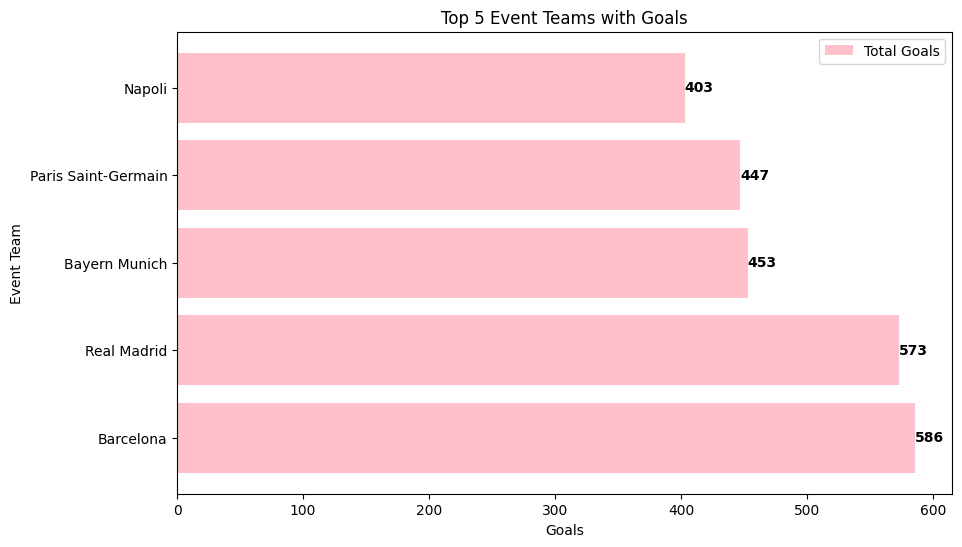

In [ ]:
import matplotlib.pyplot as plt

goal_counts = eventsDf.filter(eventsDf.is_goal == 1).groupBy('event_team').count().orderBy('count', ascending=False).toPandas()

top_5_goal_counts = goal_counts.head(5)

plt.figure(figsize=(10, 6))

teams = top_5_goal_counts['event_team']
total_goals = top_5_goal_counts['count']

plt.barh(teams, total_goals, color='pink', label='Total Goals')

for i, v in enumerate(total_goals):
    plt.text(v, i, str(v), va='center', color='black', fontweight='bold')

plt.xlabel('Goals')
plt.ylabel('Event Team')
plt.title('Top 5 Event Teams with Goals')
plt.legend()

plt.show()


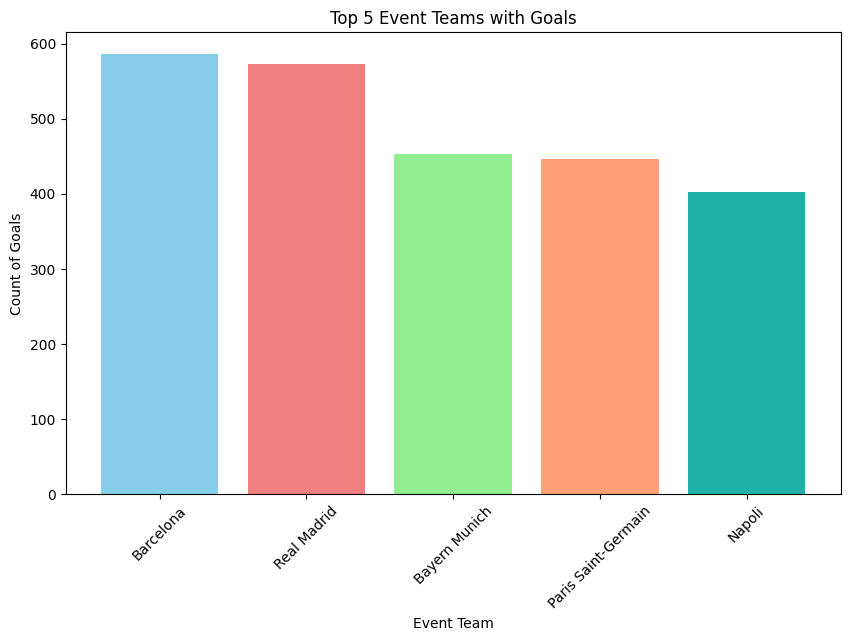

In [ ]:
import matplotlib.pyplot as plt

goal_counts = eventsDf.filter(eventsDf.is_goal == 1).groupBy('event_team').count().orderBy('count', ascending=False).toPandas()

top_5_goal_counts = goal_counts.head(5)

# Define a color palette
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightseagreen']

plt.figure(figsize=(10, 6))
plt.bar(top_5_goal_counts['event_team'], top_5_goal_counts['count'], color=colors)
plt.title('Top 5 Event Teams with Goals')
plt.xlabel('Event Team')
plt.ylabel('Count of Goals')
plt.xticks(rotation=45)
plt.show()


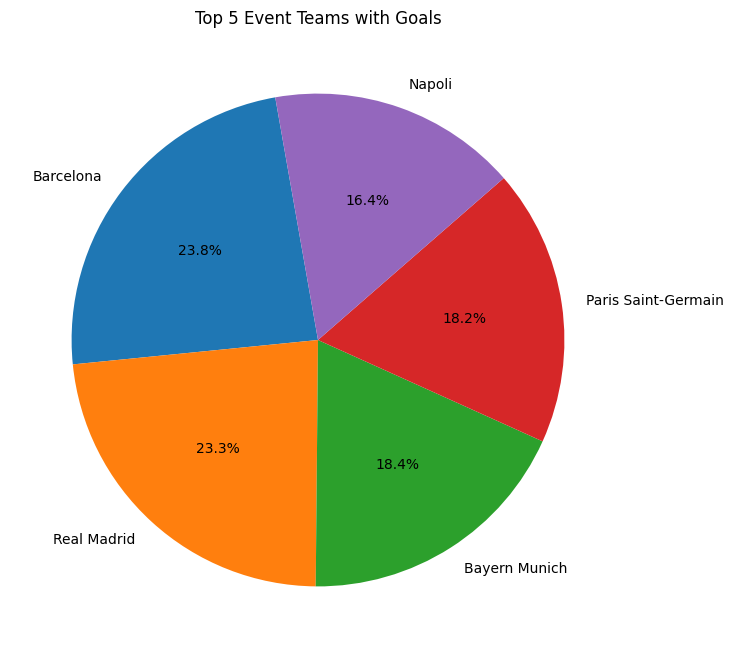

In [ ]:
import matplotlib.pyplot as plt

goal_counts = eventsDf.filter(eventsDf.is_goal == 1).groupBy('event_team').count().orderBy('count', ascending=False).toPandas()

top_5_goal_counts = goal_counts.head(5)

plt.figure(figsize=(8, 8))
plt.pie(top_5_goal_counts['count'], labels=top_5_goal_counts['event_team'], autopct='%1.1f%%', startangle=100)
plt.title('Top 5 Event Teams with Goals')

plt.show()

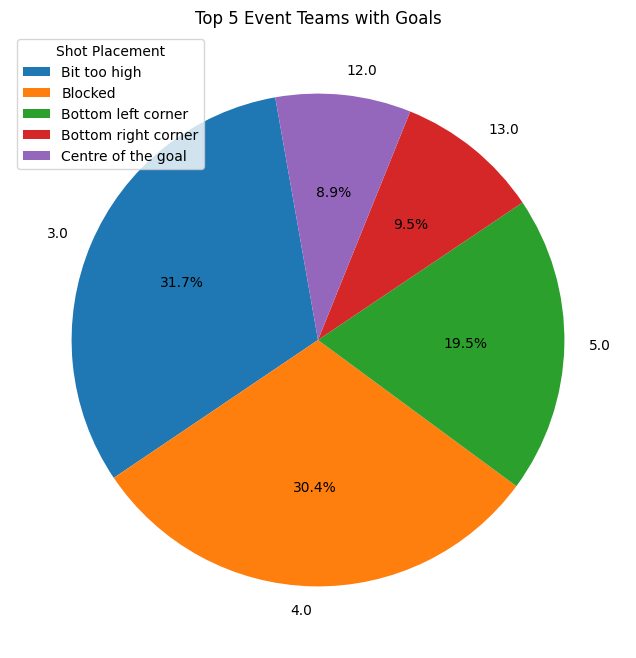

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'top_5_goal_counts' with 'shot_place' and 'count' columns
# 'top_5_goal_counts' should be sorted in the order you want for the legend labels
goal_counts = eventsDf.filter(eventsDf.is_goal == 1).groupBy('shot_place').count().orderBy('count', ascending=False).toPandas()

# Select the top 5 shot placements
top_5_goal_counts = goal_counts.head(5)
plt.figure(figsize=(8, 8))
plt.pie(top_5_goal_counts['count'], labels=top_5_goal_counts['shot_place'], autopct='%1.1f%%', startangle=100)
plt.title('Top 5 Event Teams with Goals')

# Customize the legend
legend_labels = [
    "Bit too high",
    "Blocked",
    "Bottom left corner",
    "Bottom right corner",
    "Centre of the goal",
    "High and wide",
    "Hits the bar",
    "Misses to the left",
    "Misses to the right",
    "Too high",
    "Top centre of the goal",
    "Top left corner",
    "Top right corner"
]

# Create a legend with custom labels
plt.legend(legend_labels, title="Shot Placement", loc="upper left")

# You can further customize the chart if needed
plt.show()


***MACHINE LEARNING***

---


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
categFeatures = ["event_type_str", "event_team", "shot_place_str", "location_str", "assist_method_str", "situation_str", "country_code"]

stringIndexers = [StringIndexer().setInputCol(baseFeature).setOutputCol(baseFeature + "_idx") for baseFeature in categFeatures]

encoders = [OneHotEncoder().setInputCol(baseFeature + "_idx").setOutputCol(baseFeature + "_vec") for baseFeature in categFeatures]

featureAssembler = VectorAssembler()
featureAssembler.setInputCols([baseFeature + "_vec" for baseFeature in categFeatures])
featureAssembler.setOutputCol("features")

VectorAssembler_2ebca124b422

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score, matthews_corrcoef, cohen_kappa_score
import pandas as pd

spark = SparkSession.builder.appName("ClassificationMetrics").getOrCreate()

(trainingData, testData) = finalDf.randomSplit([0.75, 0.25])

classifiers = {
    "Naive Bayes": NaiveBayes(labelCol="is_goal", featuresCol="features", smoothing=1.0),
    "Random Forest": RandomForestClassifier(labelCol="is_goal", featuresCol="features", numTrees=10),
    "GBT Classifier": GBTClassifier(labelCol="is_goal", featuresCol="features", maxDepth=5, maxIter=20),
    "SVM": LinearSVC(labelCol="is_goal", featuresCol="features", maxIter=100)
}

accuracy_list, precision_list, recall_list, f1_list, roc_auc_list, avg_precision_list, mcc_list, kappa_list = [], [], [], [], [], [], [], []

for classifier_name, classifier in classifiers.items():
    pipelineStages = stringIndexers + encoders + [featureAssembler, classifier]
    pipeline = Pipeline(stages=pipelineStages)

    model = pipeline.fit(trainingData)

    predictions = model.transform(testData)

    true_labels = [int(row.is_goal) for row in predictions.select("is_goal").collect()]
    model_predictions = [int(row.prediction) for row in predictions.select("prediction").collect()]

    evaluator = BinaryClassificationEvaluator(labelCol="is_goal", rawPredictionCol="prediction")
    evaluation = evaluator.evaluate(predictions)

    accuracy = accuracy_score(true_labels, model_predictions)
    precision = precision_score(true_labels, model_predictions)
    recall = recall_score(true_labels, model_predictions)
    f1 = f1_score(true_labels, model_predictions)
    roc_auc = roc_auc_score(true_labels, model_predictions)
    avg_precision = average_precision_score(true_labels, model_predictions)
    mcc = matthews_corrcoef(true_labels, model_predictions)
    kappa = cohen_kappa_score(true_labels, model_predictions)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    avg_precision_list.append(avg_precision)
    mcc_list.append(mcc)
    kappa_list.append(kappa)

metrics_dict = {
    "Classifier": list(classifiers.keys()),
    "Accuracy": accuracy_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "F1-Score": f1_list,
    "ROC AUC": roc_auc_list,
    "Avg Precision (AUC-PR)": avg_precision_list,
    "MCC": mcc_list,
    "Cohen's Kappa": kappa_list
}

metrics_df = pd.DataFrame(metrics_dict)

print(metrics_df)


In [ ]:
from tabulate import tabulate
table = tabulate(metrics_df, headers="keys", tablefmt="pretty", showindex=False)
print(table)

In [ ]:
finalDf.createOrReplaceTempView("soccer")

In [ ]:
tot_goals = spark.sql("SELECT country, COUNT(1) AS TOT_GOALS FROM soccer WHERE is_goal = 1 GROUP BY country\
                    ORDER BY 2 DESC")
tot_goals.show()

In [ ]:
import matplotlib.pyplot as plt
tot_goals_pd = tot_goals.toPandas()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(tot_goals_pd['TOT_GOALS'], labels=tot_goals_pd['country'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Set a title
plt.title('Distribution of Total Goals by Country')

# Display the chart
plt.show()


In [ ]:
num_of_goals = spark.sql("SELECT time_bin, count(1) as num_of_goals FROM soccer \
                    WHERE is_goal = 1 GROUP BY time_bin ORDER BY 1")

num_of_goals.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the 'num_of_goals' DataFrame
num_of_goals_pd = num_of_goals.toPandas()

plt.figure(figsize=(10, 5))
plt.fill_between(num_of_goals_pd['time_bin'], num_of_goals_pd['num_of_goals'], alpha=0.2)
plt.plot(num_of_goals_pd['time_bin'], num_of_goals_pd['num_of_goals'], color='b')
plt.title('Number of Goals by Time Bin')
plt.xlabel('Time Bin')
plt.ylabel('Number of Goals')
plt.grid(True)
plt.show()


In [ ]:
goals = num_of_goals.toPandas()

plot3_ = goals.plot.bar(x='time_bin', y='num_of_goals', figsize=(20,5))

In [ ]:
country_goals = spark.sql("SELECT country, TIME_BIN, COUNT(1) TOT_GOALS \
                  FROM soccer \
                  WHERE is_goal = 1 \
                  GROUP BY country, TIME_BIN \
                  ORDER BY country, TIME_BIN")
country_goals.show(50)

In [ ]:
line = country_goals.toPandas()

df = line.pivot(index='TIME_BIN', columns='country', values='TOT_GOALS')

lines = df.plot.line(figsize=(15, 5))